# Black Lives Matter: Topic Modeling

This analysis was inspired by the [_Topic Modeling with Gensim (Python)_ post](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/), which can be found on the Machine Learning Plus blog.

## Import libraries

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/opardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter
import random

In [3]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas_gbq

In [4]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, ldamodel
from gensim.test.utils import datapath

In [5]:
# spacy for lemmatization
import spacy

In [6]:
# Plotting tools
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

In [7]:
# Parallelize prediction
import multiprocessing

In [8]:
import pyLDAvis
import pyLDAvis.gensim

In [9]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [10]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [11]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['url','ferguson', 'michael', 'mike', 'brown', 'michaelbrown', 'mikebrown'])

## Import data

In [12]:
%env GOOGLE_APPLICATION_CREDENTIALS = ../dsi-capstone-f19-group-1-670a48d72abe.json

env: GOOGLE_APPLICATION_CREDENTIALS=../dsi-capstone-f19-group-1-670a48d72abe.json


In [13]:
%load_ext google.cloud.bigquery

In [14]:
%%bigquery df
SELECT DISTINCT full_text_cleaned AS full_text
FROM tweets.all_valid_tweets
WHERE ferguson_ht + michael_brown = 2 AND is_retweet = FALSE

In [15]:
data = list(df['full_text'])

## Pre-processing tweets

### Decompose into bag of words

Let's take a tweet in our data:

In [16]:
tweet = 'News: Man who shot video of Eric Garner in apparent choke hold arrested on firearms charges.'
print(tweet)

News: Man who shot video of Eric Garner in apparent choke hold arrested on firearms charges.


Now we will decompose this tweet into an array of words, where the order doesn't matter.

In [17]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
    
data_words = list(sent_to_words(data))

#Example
tweet_words = list(sent_to_words([tweet]))
print(tweet_words[0])

['news', 'man', 'who', 'shot', 'video', 'of', 'eric', 'garner', 'in', 'apparent', 'choke', 'hold', 'arrested', 'on', 'firearms', 'charges']


### Stop words

There are commonly used words (such as “the”, “a”, “an”, “in”) which appear that often, that are useless to understand the context we are analyzing. Moreover, since they are common, they make the NLP techniques to spend more time processing, without adding any value. Therefore, we will remove them from every tweet.

In [18]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def unique_list_of_lists(lol):
    unique_lol = set(map(tuple, lol))
    unique_lol = list(map(list, unique_lol))
    return(unique_lol)

# Remove Stop Words
data_words_nostops = unique_list_of_lists(remove_stopwords(data_words))

#Example
tweet_words_nostops = remove_stopwords(tweet_words)
print(tweet_words_nostops[0])

['news', 'man', 'shot', 'video', 'eric', 'garner', 'apparent', 'choke', 'hold', 'arrested', 'firearms', 'charges']


### Bigrams and Trigrams

There are concepts like _Eric Garner_ or _New York_ which make more sense to be analyzed as a single word, than being split into two. To achieve that we will use the concept of bigrams and trigrams.

In [19]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words_nostops, min_count=5, threshold=20) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words_nostops], threshold=20)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [20]:
def make_bigrams(texts):
    return [remove_underscore(bigram_mod[doc]) for doc in texts]

def make_trigrams(texts):
    return [remove_underscore(trigram_mod[bigram_mod[doc]]) for doc in texts]

def remove_underscore(doc):
    return([re.sub("_", "", word) for word in doc])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [21]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Example
tweet_words_bigrams = make_bigrams(tweet_words_nostops)
print(tweet_words_bigrams[0])

['news', 'man', 'shot', 'video', 'ericgarner', 'apparent', 'choke', 'hold', 'arrested', 'firearms', 'charges']


### Lemmatization

Finally, we would like to tackle one last challenge: The fact that a word used as a singular or plural should be considered the same. Similar case when you conjugate a verb or you use verbs and adjectives with the same origin. 

These kinds of problems are solved by _Lemmatization_ , a technique that transforms any single word to its root.

In [22]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized =  unique_list_of_lists(remove_stopwords(
    lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
))

# Example
tweet_lemmatized = lemmatization(tweet_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(tweet_lemmatized[0])

['news', 'man', 'shoot', 'video', 'ericgarner', 'apparent', 'choke', 'hold', 'arrest', 'firearm', 'charge']


## Modeling topics

### Build corpora

Once we have the pre-processed tweets we want to model, we need to make them comparable on a mathematical way. To achieve that, we will create as many dimensions as we have unique words in the set of tweets. Then, we will assign to each word the number of times it was mentioned in the tweet (and zero if it didn't appear).

In [23]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Example
print(id2word.doc2bow(tweet_lemmatized[0]))

[(4, 1), (41, 1), (182, 1), (253, 1), (254, 1), (376, 1), (390, 1), (684, 1), (4335, 1), (6262, 1), (7073, 1)]


In [24]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in [id2word.doc2bow(tweet) for tweet in tweet_lemmatized]]

[[('man', 1),
  ('video', 1),
  ('shoot', 1),
  ('arrest', 1),
  ('charge', 1),
  ('ericgarner', 1),
  ('hold', 1),
  ('news', 1),
  ('choke', 1),
  ('apparent', 1),
  ('firearm', 1)]]

### LDA Model

To model the different topics, we are going to use the Latent Dirichlet Allocation (LDA) technique. Specifically, we are going to use the Mallet implementation, which is a Java-based package for statistical NLP.

In [25]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                            corpus=corpus,
                                            num_topics=10,
                                            id2word=id2word,
                                            alpha=1,
                                            optimize_interval=50,
                                            workers=7,
                                            random_seed=2019)

In [26]:
lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

This will give us 10 different topics (a fixed parameter we used). Now, we are going to explore the 10 words most representative of each of these topics. 

In [27]:
# Show Topics
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('family', 0.01657658249683747),
   ('speak', 0.015952290985559153),
   ('funeral', 0.015015853718641673),
   ('talk', 0.010005092904434113),
   ('live', 0.0088057960538205),
   ('watch', 0.007787215166997979),
   ('johnson', 0.006768634280175459),
   ('today', 0.006193628940840165),
   ('discuss', 0.006160771492878148),
   ('listen', 0.005815768289276972)]),
 (1,
  [('police', 0.041400370814701715),
   ('people', 0.014090958665067073),
   ('justice', 0.010317373759406697),
   ('cop', 0.010251935870869233),
   ('make', 0.006380194132402661),
   ('violence', 0.006063911004471589),
   ('protest', 0.005998473115934126),
   ('loot', 0.005736721561784273),
   ('riot', 0.005638564728978078),
   ('murder', 0.005387719489584469)]),
 (2,
  [('police', 0.05870672304097043),
   ('protest', 0.01988409947453025),
   ('protester', 0.01939780356346837),
   ('missouri', 0.01452133623309784),
   ('tearga', 0.014426778694835808),
   ('shoot', 0.014305204717070337),
   ('arrest', 0.01340015399370

Finally, we will obtain the coherence score, a metric that will indicate how good the model fit is.

In [28]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.30005896379295255


### Choosing the number of topics

As we mentioned before, the number of topics was fixed to 10. However, we would like to optimize that hyper-parameter as well to improve the model performance. To achieve that we will use the Coherence Score, trying different values, and analyzing which is the one with the best performance.

In [29]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        mallet_model = gensim.models.wrappers.LdaMallet(mallet_path,
                                            corpus=corpus,
                                            num_topics=num_topics,
                                            id2word=id2word,
                                            alpha=1,
                                            optimize_interval=50,
                                            workers=7,
                                            random_seed=2019)
        
        model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_model)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [30]:
# Can take a long time to run.
limit = 18
start = 6
step = 2
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=texts, 
                                                        start=start, 
                                                        limit=limit,
                                                        step=step)

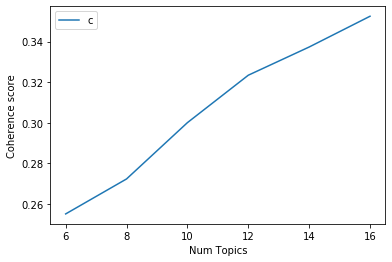

In [31]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [32]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 6  has Coherence Value of 0.2551
Num Topics = 8  has Coherence Value of 0.2723
Num Topics = 10  has Coherence Value of 0.3001
Num Topics = 12  has Coherence Value of 0.3234
Num Topics = 14  has Coherence Value of 0.3373
Num Topics = 16  has Coherence Value of 0.3525


### Working with the optimal model

The model we liked the most was the one with 8 topics. Although the 4-theme model has the best performance, the 8-theme balances the diversity of topics with acceptable performance.

In [33]:
file_name = 'optimal_model'

In [34]:
# optimal_model = model_list[3]
# optimal_model.save(file_name)

In [35]:
optimal_model = ldamodel.LdaModel.load(file_name, mmap='r')
id2word = corpora.Dictionary.load('optimal_model.id2word', mmap='r')

In [36]:
# Print the topics
pprint(optimal_model.show_topics(formatted=False, num_topics=20))

[(0,
  [('police', 0.06555450840238425),
   ('protester', 0.019020109420706706),
   ('protest', 0.018897714894189933),
   ('tearga', 0.013279806127069997),
   ('arrest', 0.011994663598643868),
   ('missouri', 0.011407169871363353),
   ('shoot', 0.009767083216038579),
   ('cop', 0.009167350036106385),
   ('curfew', 0.008934800435724515),
   ('stl', 0.008702250835342644)]),
 (1,
  [('news', 0.014670798255957442),
   ('death', 0.01336825074725094),
   ('story', 0.013052897139879891),
   ('shooting', 0.012202813502618806),
   ('read', 0.010817999835467683),
   ('follow', 0.010667178544985877),
   ('tweet', 0.010050182356651218),
   ('watch', 0.009789672854909918),
   ('medium', 0.00939205308909425),
   ('coverage', 0.009350920009871939)]),
 (2,
  [('protest', 0.027783970007092918),
   ('rally', 0.022879724389502483),
   ('solidarity', 0.02172459215726011),
   ('nmos', 0.021400344513121897),
   ('justice', 0.020772114702604115),
   ('march', 0.01994123011449995),
   ('support', 0.0190698145

## Exploring the results

### Dominant topic in each sentence

In [37]:
def create_corpus(data):
    data_words = list(sent_to_words(data))
    data_words_nostops = remove_stopwords(data_words)
    data_words_bigrams = make_bigrams(data_words_nostops)
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    corpus = [id2word.doc2bow(text) for text in data_lemmatized]
    return(corpus)


def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    words = list(sent_to_words(texts))
    
    try:
        cpus = multiprocessing.cpu_count()
    except NotImplementedError:
        cpus = 7   # arbitrary default
    
    pool = multiprocessing.Pool(processes=cpus)
    dom_topics_list = pool.map(get_dominant_topic, list(ldamodel[corpus]))
    pool.close()
    
    df_dominant_topic = pd.DataFrame(dom_topics_list)

    # Add original text to the end of the output
    contents = pd.Series(texts)
    bow = pd.Series(words)
    df_dominant_topic = pd.concat([df_dominant_topic, contents, bow], axis=1).reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Text', 'Words']
    
    topic_keywords_dict = get_topic_keywords_dict(ldamodel)
    df_dominant_topic['Topic_Keywords'] = list(map(
        lambda x:topic_keywords_dict[x],
        df_dominant_topic['Dominant_Topic']
    ))
    df_dominant_topic = df_dominant_topic[['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Topic_Keywords', 'Text', 'Words']]
    
    return(df_dominant_topic)


def get_dominant_topic(topics):
    topic_num, prop_topic = sorted(topics, key=lambda x: (x[1]), reverse=True)[0]
    prop_topic = round(prop_topic,4)
    return(topic_num + 1, prop_topic)


def get_topic_keywords_dict(ldamodel):
    topic_keywords_dict = {}
    for topic in ldamodel.show_topics(formatted=False, num_topics=20):
        topic_num, topic_keywords = topic
        topic_num += 1
        topic_keywords = ", ".join([word for word, prop in topic_keywords])
        topic_keywords_dict[topic_num] = topic_keywords
    return(topic_keywords_dict)

In [38]:
corpus_ = create_corpus(data)
df_dominant_topic = format_topics_sentences(optimal_model, corpus_, data)

In [39]:
# Show
pd.set_option('display.max_colwidth', -1)
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Topic_Keywords,Text,Words
0,0,6,0.9276,"shoot, time, shot, officer, cop, darrenwilson, head, police, autopsy, kill",ferguson dr baden said there are abrasions to right side of mikebrowns face which likely happened after shot and he fell flat down,"[ferguson, dr, baden, said, there, are, abrasions, to, right, side, of, mikebrowns, face, which, likely, happened, after, shot, and, he, fell, flat, down]"
1,1,8,0.6635,"black, police, kill, white, cop, people, murder, man, unarmed, shoot",many respected black voices get too excited when a white persona agrees w us welcome support adore only the cause ferguson mikebrown,"[many, respected, black, voices, get, too, excited, when, white, persona, agrees, us, welcome, support, adore, only, the, cause, ferguson, mikebrown]"
2,2,1,0.8939,"police, protester, protest, tearga, arrest, missouri, shoot, cop, curfew, stl",shots fired at walgreens on west florissant and chambers stl ferguson mikebrown,"[shots, fired, at, walgreens, on, west, florissant, and, chambers, stl, ferguson, mikebrown]"
3,3,1,0.8711,"police, protester, protest, tearga, arrest, missouri, shoot, cop, curfew, stl",if ferguson police have nothing to hide why all the censorship? mikebrown mediablackout,"[if, ferguson, police, have, nothing, to, hide, why, all, the, censorship, mikebrown, mediablackout]"
4,4,12,0.8293,"police, case, justice, death, investigation, shoot, grandjury, obama, stlouis, ericholder",official statement by the ferguson police department ferguson mikebrown justice $URL$,"[official, statement, by, the, ferguson, police, department, ferguson, mikebrown, justice, url]"
5,5,12,0.8896,"police, case, justice, death, investigation, shoot, grandjury, obama, stlouis, ericholder",obama have tasked dept of justice fbi to investigate death of michael brown in ferguson,"[obama, have, tasked, dept, of, justice, fbi, to, investigate, death, of, michael, brown, in, ferguson]"
6,6,11,0.4448,"cop, police, video, robbery, murder, store, darrenwilson, shoot, pd, show",did anybody see segment on ? ferguson mikebrown wow! she kept insinuating that the police force was justified!!!,"[did, anybody, see, segment, on, ferguson, mikebrown, wow, she, kept, insinuating, that, the, police, force, was, justified]"
7,7,8,0.7823,"black, police, kill, white, cop, people, murder, man, unarmed, shoot",take down the darren wilson fundraisers and return all profits! $URL$ mikebrown ferguson,"[take, down, the, darren, wilson, fundraisers, and, return, all, profits, url, mikebrown, ferguson]"
8,8,11,0.6470,"cop, police, video, robbery, murder, store, darrenwilson, shoot, pd, show",if ferguson cop suspected mikebrown of robbery w assault why would he try to talk to him from his car window?,"[if, ferguson, cop, suspected, mikebrown, of, robbery, assault, why, would, he, try, to, talk, to, him, from, his, car, window]"
9,9,5,0.9176,"funeral, family, live, today, speak, watch, discuss, day, church, talk",fox news and msnbc are in commercial while cnn is showing mike browns funeral live ferguson,"[fox, news, and, msnbc, are, in, commercial, while, cnn, is, showing, mike, browns, funeral, live, ferguson]"


### Most representative tweets

In [40]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
# Group top 5 sentences under each topic
df_dominant_topic_sorted = pd.DataFrame()

df_dominant_topic_grpd = df_dominant_topic.groupby('Dominant_Topic')

for i, grp in df_dominant_topic_grpd:
    df_dominant_topic_sorted = pd.concat([df_dominant_topic_sorted, 
                                         grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(10)], 
                                         axis=0)

# Reset Index    
df_dominant_topic_sorted.reset_index(drop=True, inplace=True)

# Format
df_dominant_topic_sorted.columns = ['Document_No','Topic_Num', 'Topic_Perc_Contrib', 'Text', 'Words', 'Topic_Keywords']

# Show
df_dominant_topic_sorted

,Document_No,Topic_Num,Topic_Perc_Contrib,Text,Words,Topic_Keywords
0,98499,1,0.9590,"police, protester, protest, tearga, arrest, missouri, shoot, cop, curfew, stl",53 ladies dressed in garters expect? 53 ppl dressed in construction gear expect? 53 ferguson pd dressed in war gear expect? mikebrown,"[ladies, dressed, in, garters, expect, ppl, dressed, in, construction, gear, expect, ferguson, pd, dressed, in, war, gear, expect, mikebrown]"
1,135395,1,0.9560,"police, protester, protest, tearga, arrest, missouri, shoot, cop, curfew, stl",pure coincidence assault rifle armed cops dismount swat vehicle directly in front of media caging area! ferguson mikebrown,"[pure, coincidence, assault, rifle, armed, cops, dismount, swat, vehicle, directly, in, front, of, media, caging, area, ferguson, mikebrown]"
2,141613,1,0.9560,"police, protester, protest, tearga, arrest, missouri, shoot, cop, curfew, stl",protested peacefully and picked up trash for 5hrs mon heavy police presence riot gear k9s zero news vans or media ferguson mikebrown,"[protested, peacefully, and, picked, up, trash, for, hrs, mon, heavy, police, presence, riot, gear, zero, news, vans, or, media, ferguson, mikebrown]"
3,118781,1,0.9560,"police, protester, protest, tearga, arrest, missouri, shoot, cop, curfew, stl",stream i am mike brown is moving on a van toward police line to capture gas and police line ferguson people are peaceful just party testing,"[stream, am, mike, brown, is, moving, on, van, toward, police, line, to, capture, gas, and, police, line, ferguson, people, are, peaceful, just, party, testing]"
4,12254,1,0.9525,"police, protester, protest, tearga, arrest, missouri, shoot, cop, curfew, stl",video police caught punching a woman in the face! mikebrown fergusonriot stl ferguson looting riots $URL$ rt rt rt,"[video, police, caught, punching, woman, in, the, face, mikebrown, fergusonriot, stl, ferguson, looting, riots, url, rt, rt, rt]"
5,72916,1,0.9525,"police, protester, protest, tearga, arrest, missouri, shoot, cop, curfew, stl",against the effects of teargas mix maalox or sodium bicarbonate baking soda with water to wash eyes and face mikebrown ferguson,"[against, the, effects, of, teargas, mix, maalox, or, sodium, bicarbonate, baking, soda, with, water, to, wash, eyes, and, face, mikebrown, ferguson]"
6,134704,1,0.9525,"police, protester, protest, tearga, arrest, missouri, shoot, cop, curfew, stl",tonights mikebrown protesters bring children to the ferguson madness gunfire from the crowd forces the cops to move in tear gas batons,"[tonights, mikebrown, protesters, bring, children, to, the, ferguson, madness, gunfire, from, the, crowd, forces, the, cops, to, move, in, tear, gas, batons]"
7,78798,1,0.9525,"police, protester, protest, tearga, arrest, missouri, shoot, cop, curfew, stl",i think ferguson pd leaded video in hopes of increasing tension so they cd resume playing call of duty mikebrown stl uniteblue p2,"[think, ferguson, pd, leaded, video, in, hopes, of, increasing, tension, so, they, cd, resume, playing, call, of, duty, mikebrown, stl, uniteblue]"
8,64986,1,0.9525,"police, protester, protest, tearga, arrest, missouri, shoot, cop, curfew, stl",ppl have faces covered primarily bc of teargas deployment mine wd be covered ferguson msnbc stl mikebrown,"[ppl, have, faces, covered, primarily, bc, of, teargas, deployment, mine, wd, be, covered, ferguson, msnbc, stl, mikebrown]"
9,136813,1,0.9525,"police, protester, protest, tearga, arrest, missouri, shoot, cop, curfew, stl",florissant and lang police drove armored vehicle at twds protestors tear gas n air helicopters above gun fire ferguson mikebrown,"[florissant, and, lang, police, drove, armored, vehicle, at, twds, protestors, tear, gas, air, helicopters, above, gun, fire, ferguson, mikebrown]"


### Topic Distribution

In [41]:
# Number of Documents for Each Topic
topic_counts = df_dominant_topic['Dominant_Topic'].value_counts().sort_index()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4).sort_index()

# Topic Number and Keywords
topic_num_keywords = df_dominant_topic[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()\
    .sort_values('Dominant_Topic').set_index('Dominant_Topic')

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1).reset_index()

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,1,"police, protester, protest, tearga, arrest, missouri, shoot, cop, curfew, stl",14658,0.0959
1,2,"news, death, story, shooting, read, follow, tweet, watch, medium, coverage",14634,0.0958
2,3,"protest, rally, solidarity, nmos, justice, march, support, dontshoot, stand, today",10323,0.0676
3,4,"dontshoot, song, rt, rip, tribute, vma, listen, hiphop, supportmom, sendingkid",7135,0.0467
4,5,"funeral, family, live, today, speak, watch, discuss, day, church, talk",8633,0.0565
5,6,"shoot, time, shot, officer, cop, darrenwilson, head, police, autopsy, kill",9771,0.0640
6,7,"police, officer, shoot, darrenwilson, kill, release, shooting, chief, cop, shot",15825,0.1036
7,8,"black, police, kill, white, cop, people, murder, man, unarmed, shoot",19251,0.1260
8,9,"people, black, make, obama, shit, fuck, time, speak, white, johnson",13156,0.0861
9,10,"justice, family, people, peace, pray, community, love, hope, stand, today",15456,0.1012


## Visualization

### Length

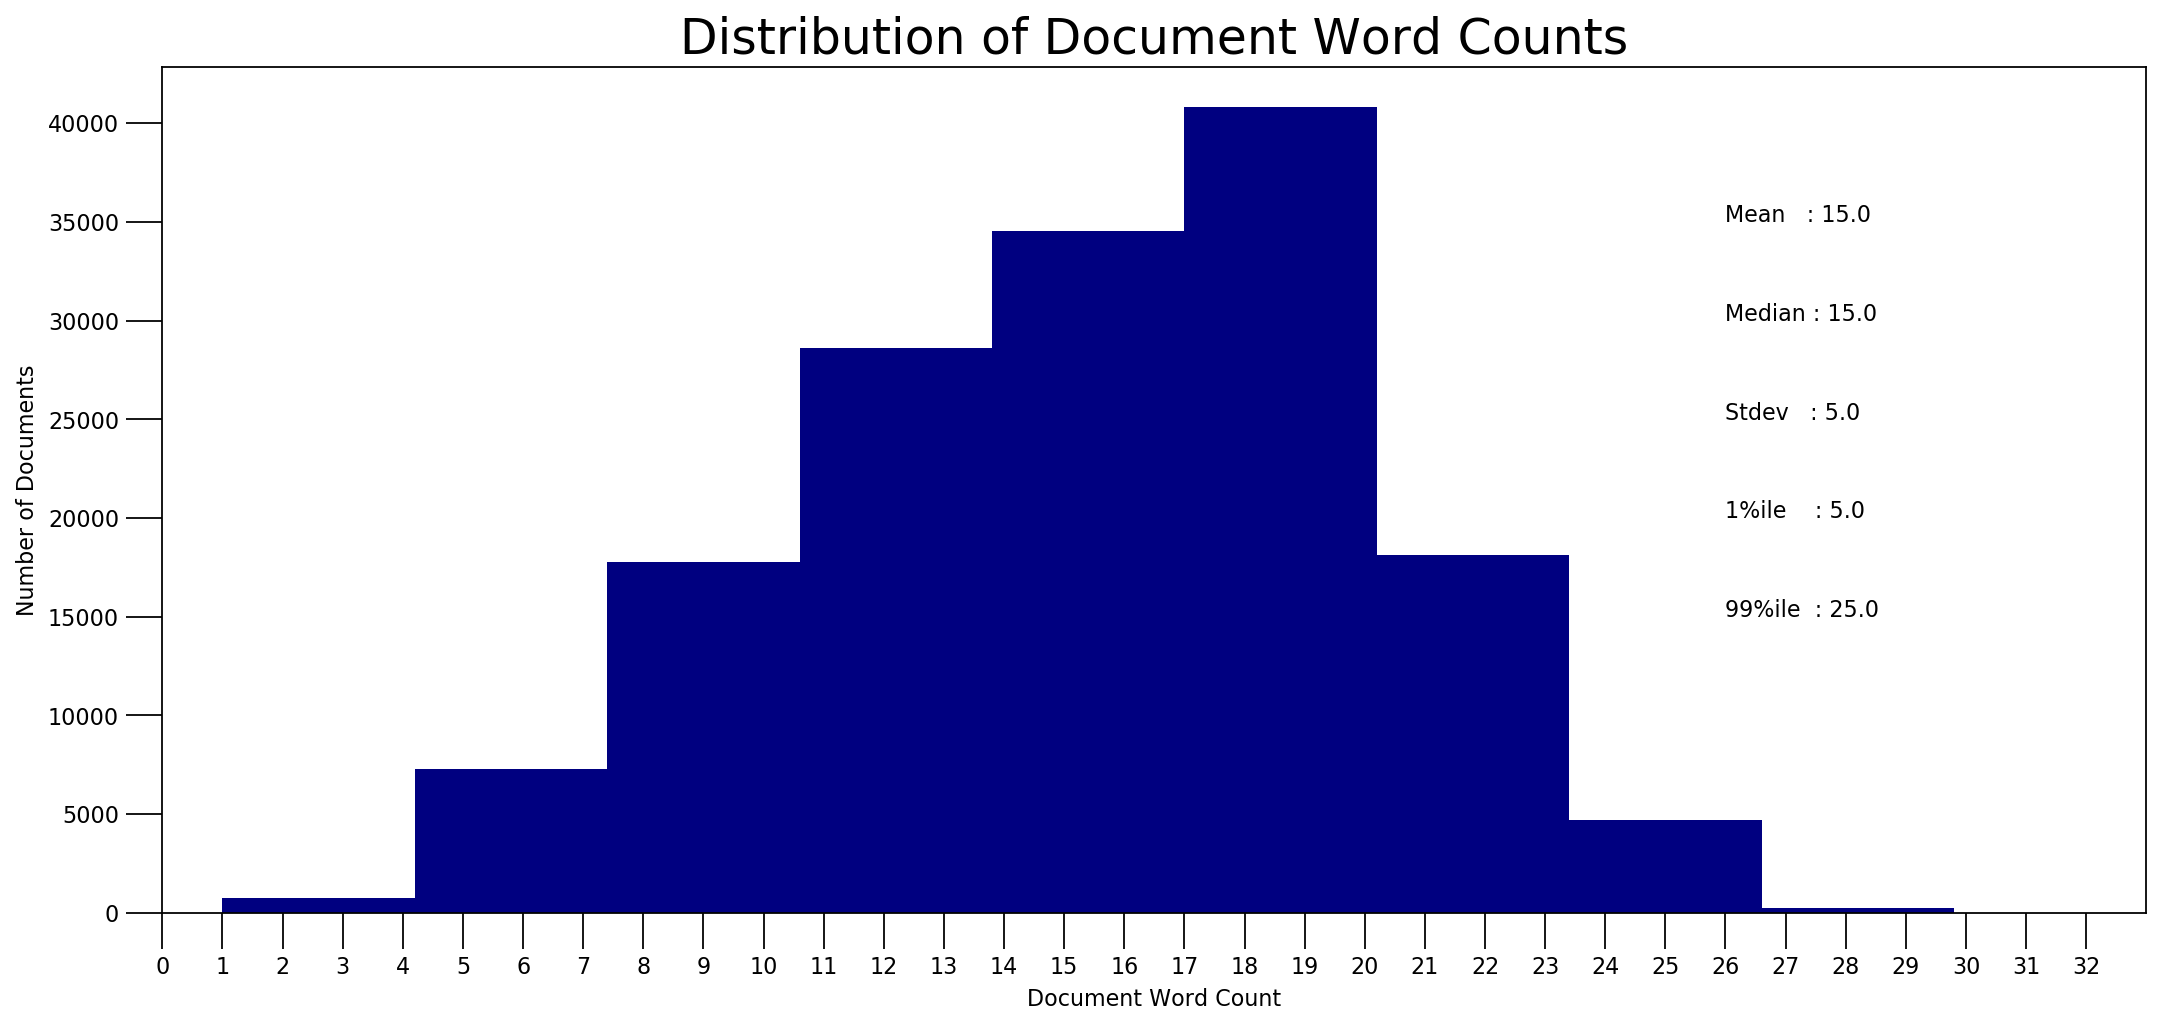

In [42]:
doc_lens = [len(d) for d in data_words]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, color='navy')
plt.text(26, 35000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(26, 30000, "Median : " + str(round(np.median(doc_lens))))
plt.text(26, 25000, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(26, 20000, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(26, 15000, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, np.max(doc_lens)), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.arange(0,np.max(doc_lens)))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

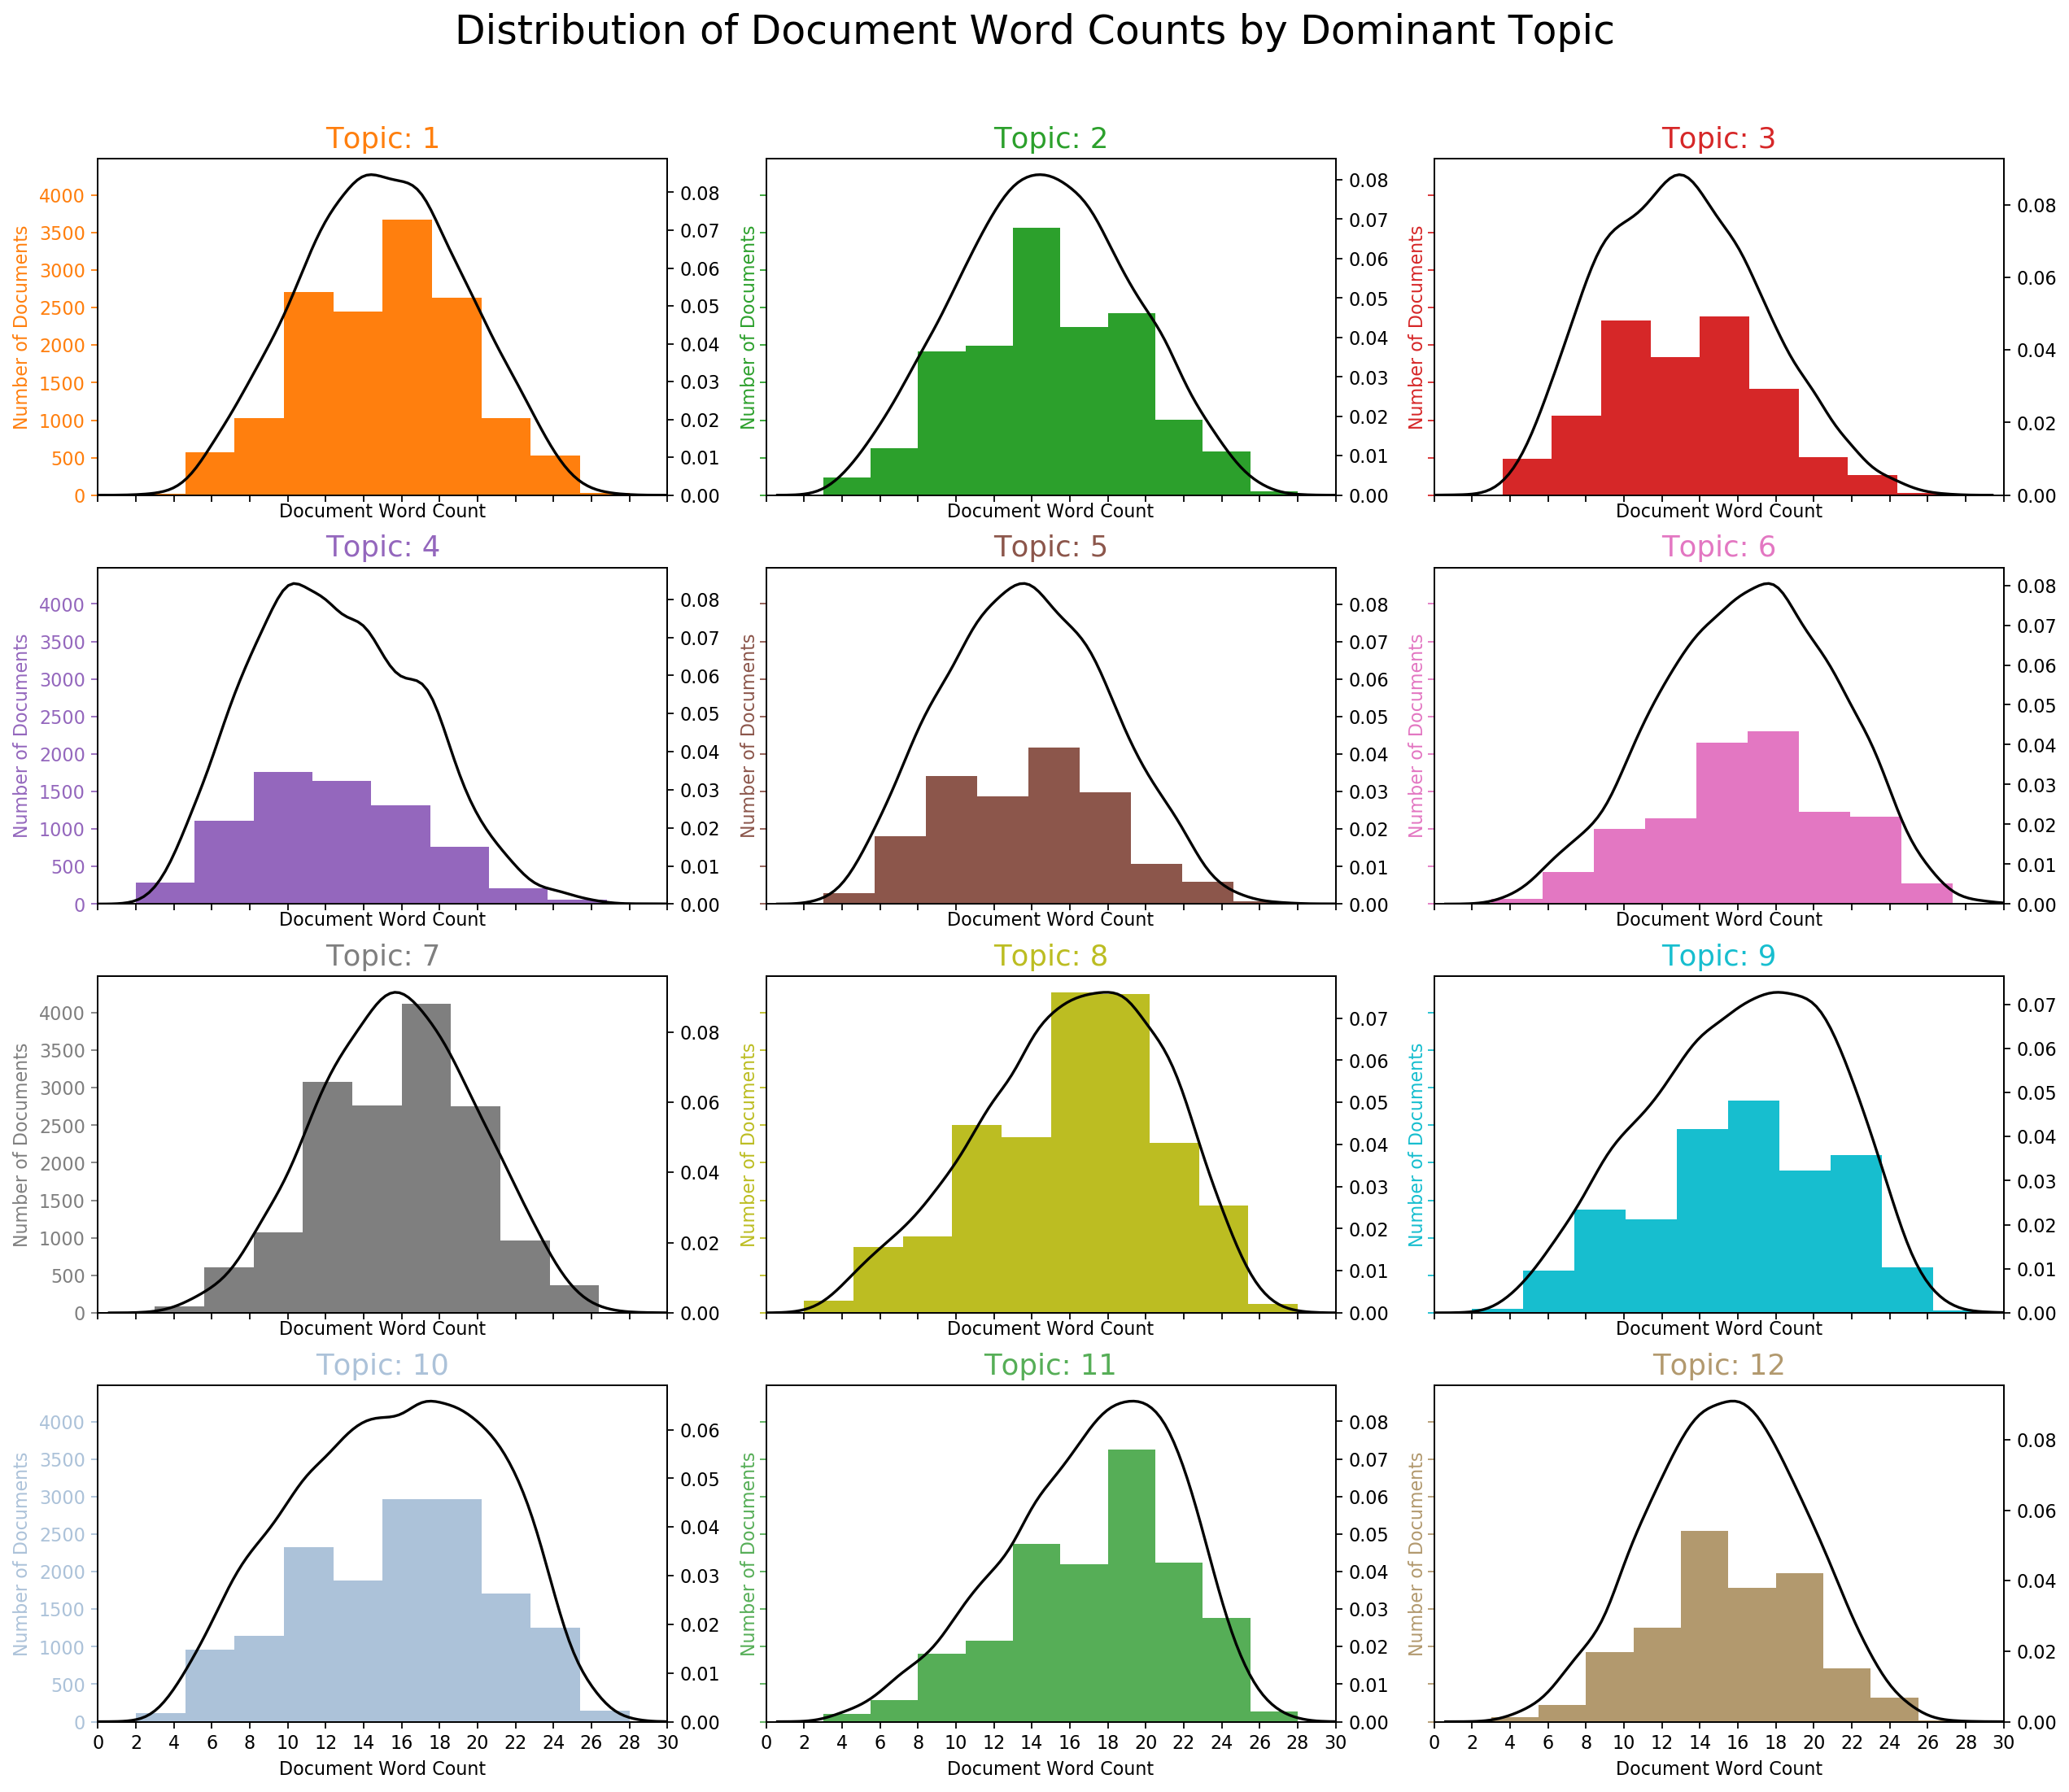

In [43]:
colors = mcolors.TABLEAU_COLORS
colors.update(mcolors.XKCD_COLORS)
cols = [color for name, color in colors.items()]  

fig, axes = plt.subplots(4,3,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    i += 1
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Words]
    ax.hist(doc_lens, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, bw=0.8, ax=ax.twinx())
    ax.set(xlim=(0, 30), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.arange(0, 32, 2))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### Word Cloud

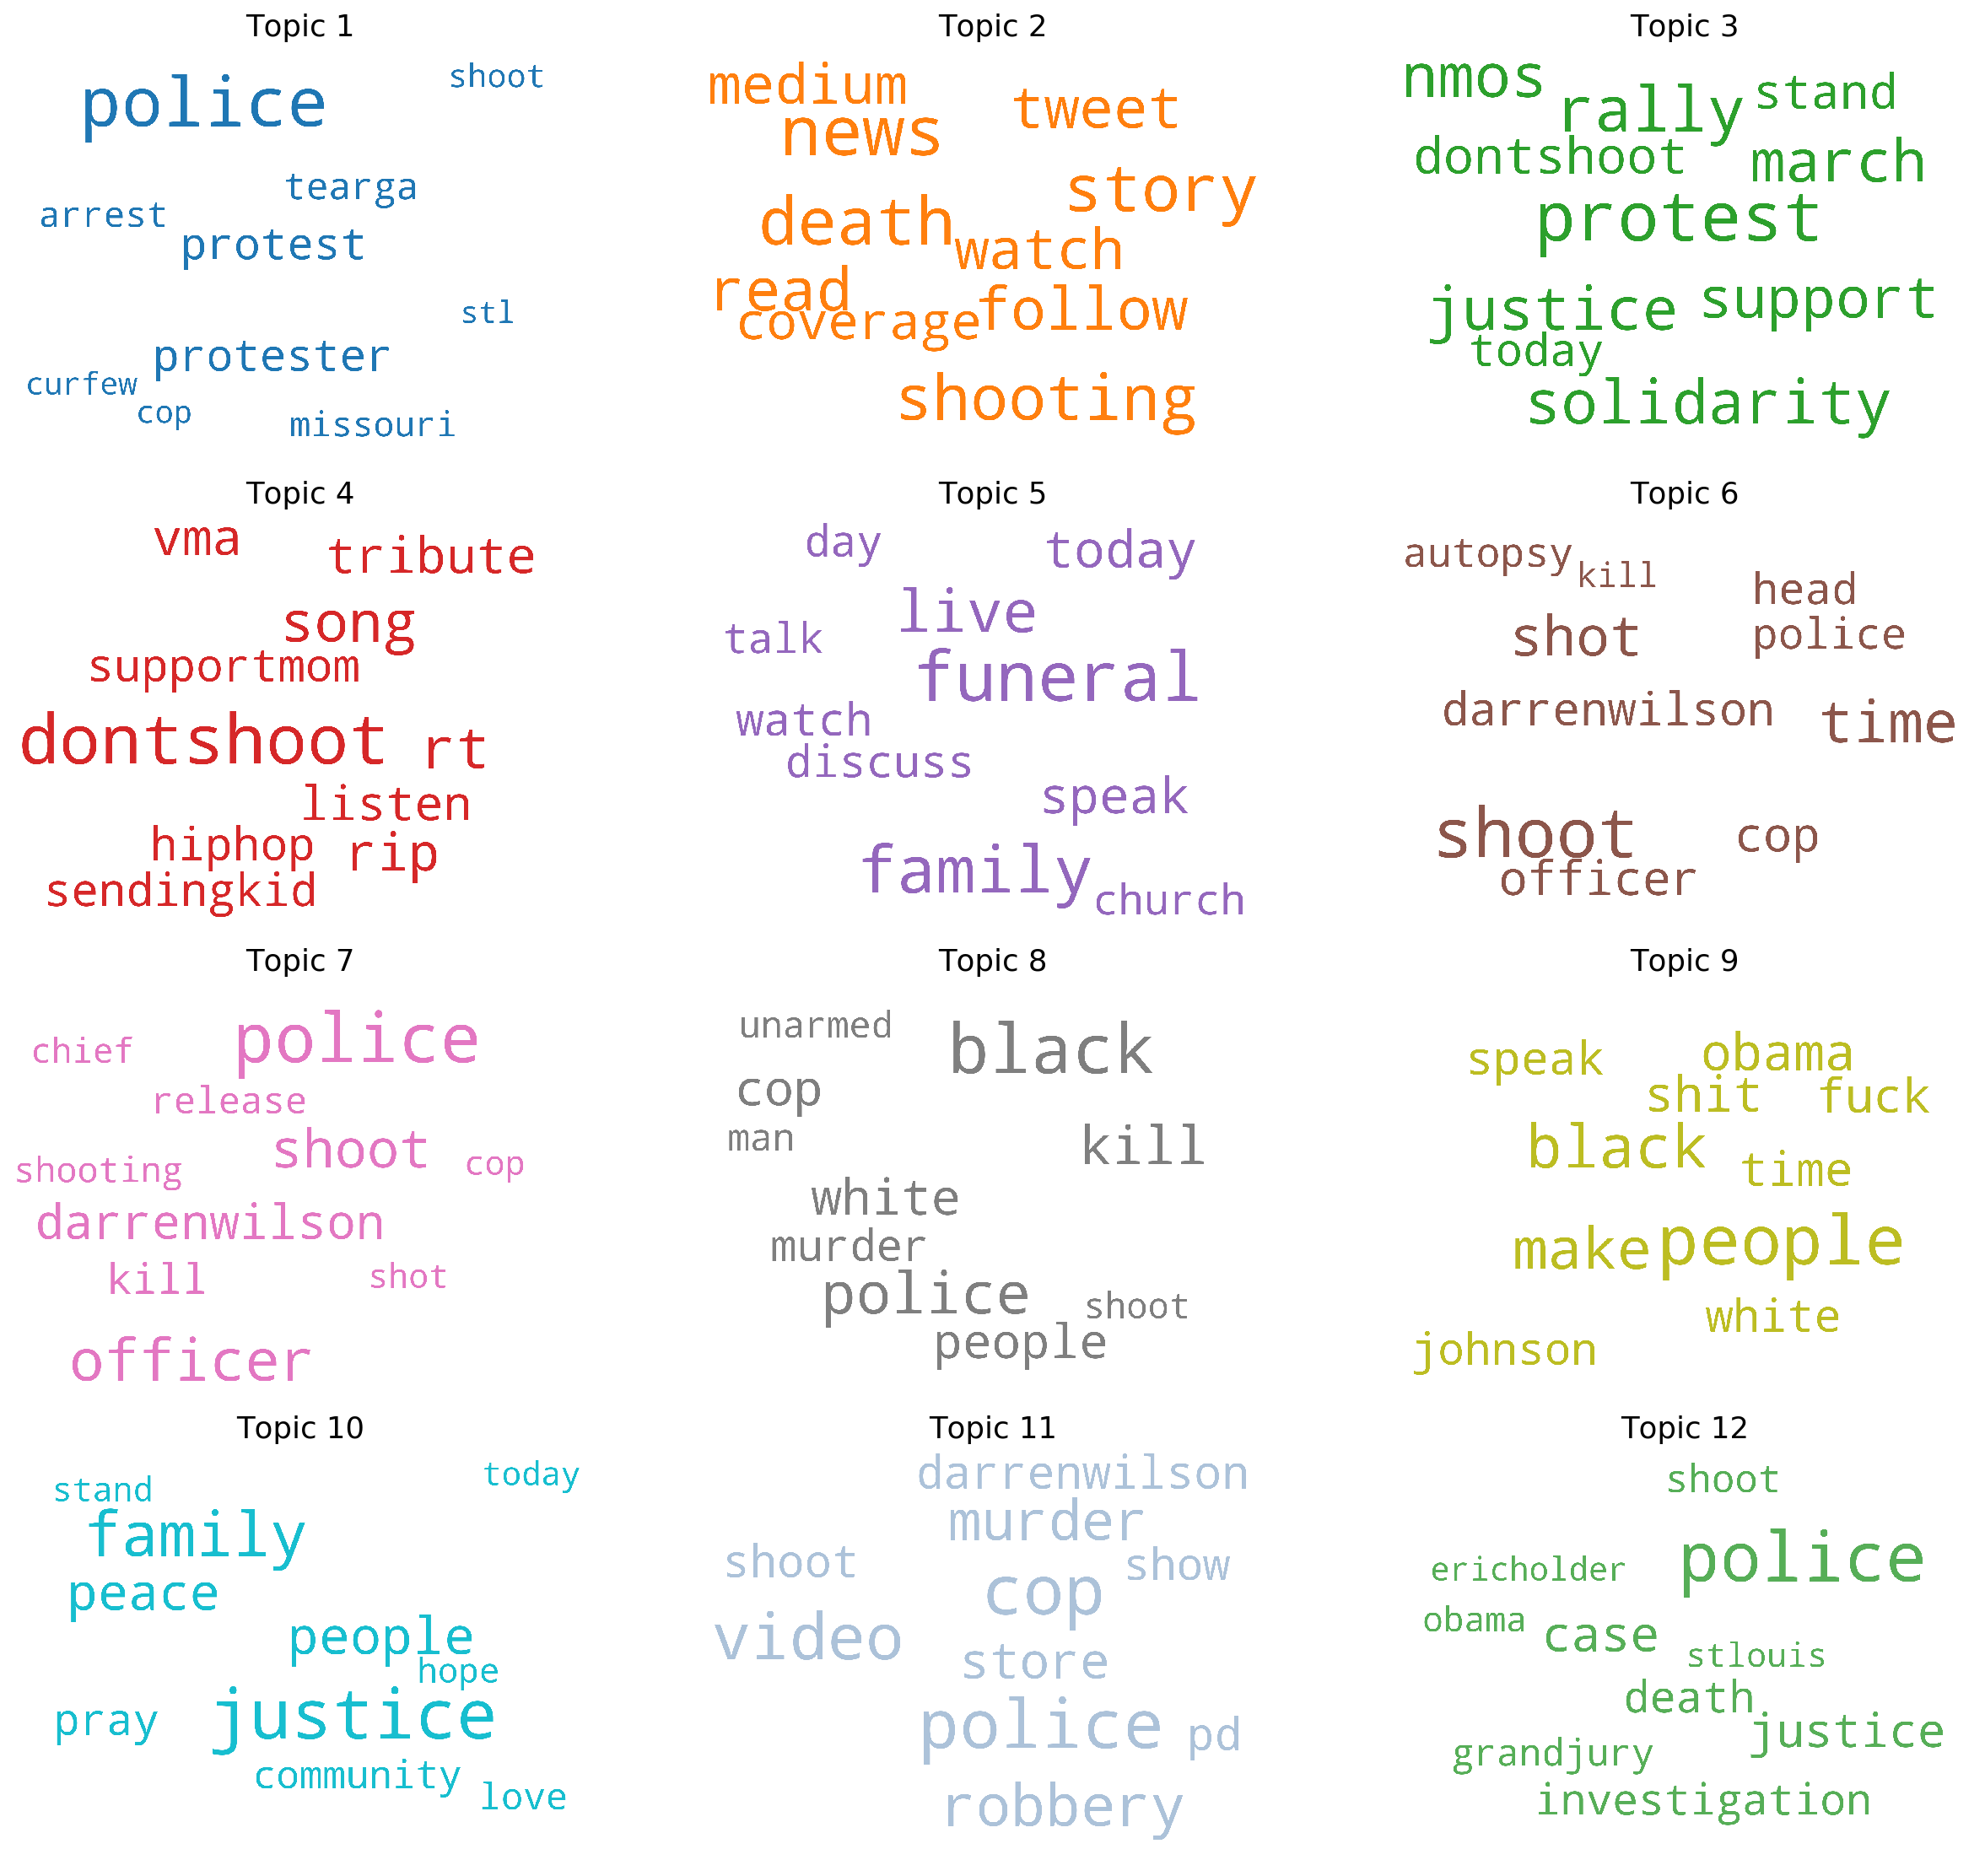

In [44]:
colors = mcolors.TABLEAU_COLORS
colors.update(mcolors.XKCD_COLORS)
cols = [color for name, color in colors.items()]  

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False, num_topics=20)

fig, axes = plt.subplots(4, 3, figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Word count of keywords

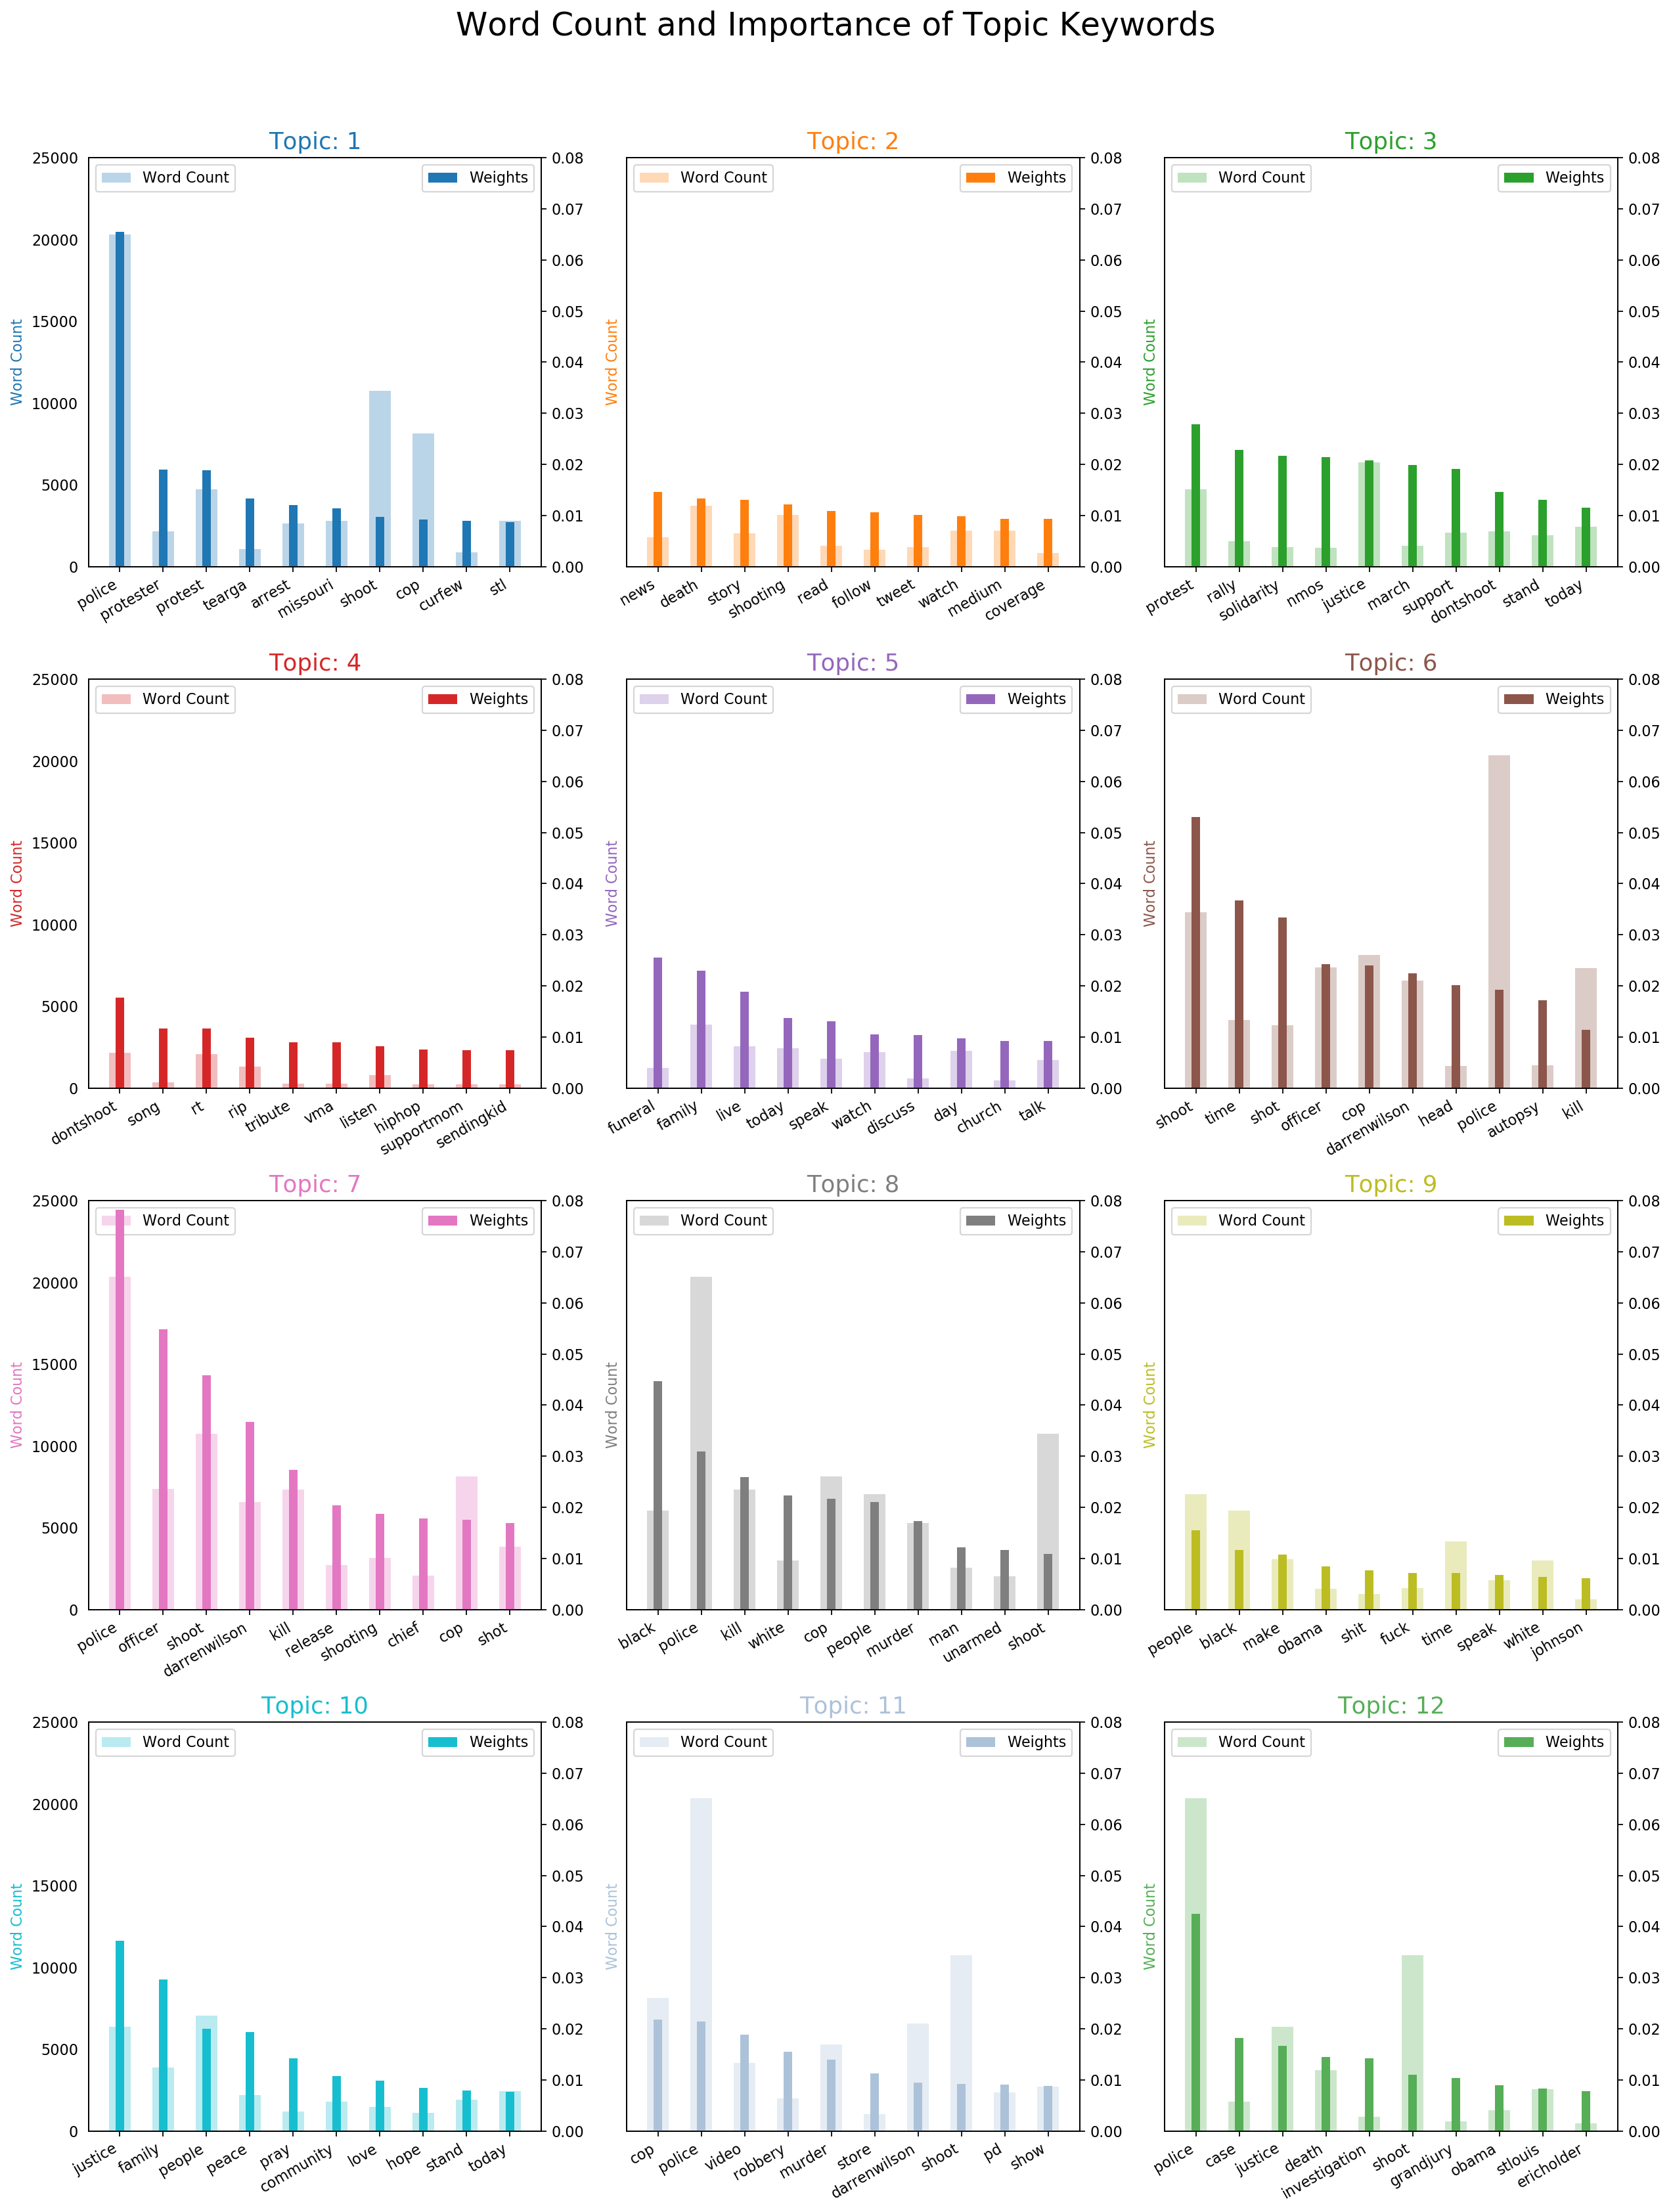

In [45]:
topics = optimal_model.show_topics(formatted=False, num_topics=20)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 3, figsize=(16,20), sharey=True, dpi=160)
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.08); ax.set_ylim(0, 25000)
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout()    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [46]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, sort_topics=False, n_jobs=-1)
vis

/Users/opardo/anaconda3/envs/CAP/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/opardo/anaconda3/envs/CAP/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/opardo/anaconda3/envs/CAP/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/Users/opardo/anaconda3/envs/CAP/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.037591  0.072211  1       1        8.648745 
1      0.056062 -0.043049  2       1        10.384227
2      0.236824  0.157614  3       1        5.636592 
3      0.231942 -0.058390  4       1        7.042956 
4      0.186476  0.179904  5       1        7.216021 
5     -0.242028  0.061733  6       1        5.061487 
6     -0.257649  0.115637  7       1        5.834161 
7     -0.100133 -0.162734  8       1        11.683645
8      0.051590 -0.214618  9       1        12.389798
9      0.185690 -0.119563  10      1        8.720197 
10    -0.206349 -0.105304  11      1        9.770660 
11    -0.104835  0.116559  12      1        7.611511 , topic_info=    Category          Freq          Term         Total  loglift  logprob
17   Default  18839.000000  police        18839.000000  30.0000  30.0000
64   Default  9720.000000   shoot         9720.000000   29.0000  29.0000
141  Default  5798.000000   officer       5798.000000   28.0000  28.0000
12   Default  6496.000000   black         6496.000000   27.0000  27.0000
5    Default  5706.000000   darrenwilson  5706.000000   26.0000  26.0000
..       ...          ...            ...          ...       ...      ...
8    Topic12  497.217976    murder        5360.873168   0.1977  -4.9531 
5    Topic12  472.697637    darrenwilson  5706.089080   0.0847  -5.0037 
161  Topic12  382.789729    family        4611.442240   0.0867  -5.2147 
201  Topic12  359.631632    release       2315.091018   0.7134  -5.2771 
115  Topic12  332.386811    kill          6756.674046  -0.4365  -5.3559 

[1307 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
11092  9      1.003309  abroad      
903    8      0.067549  accountable 
903    12     0.936036  accountable 
3199   10     0.990397  achieve     
546    1      0.052085  aclu        
...    ..          ...      ...     
37379  3      0.946318  yrd         
18215  1      1.021164  yumad       
9895   8      1.013113  zerohomicide
2492   1      0.983305  zone        
2492   3      0.018209  zone        

[2908 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

In [47]:
pyLDAvis.save_html(vis, 'pyLDAvis_ferguson_brown.html')

## Upload table with tweet-topic

In [48]:
%%bigquery df_pred
SELECT 
    id,
    REGEXP_REPLACE(full_text_cleaned, "^rt ", "") AS full_text
FROM tweets.all_valid_tweets
WHERE ferguson_ht + michael_brown = 2

In [49]:
df_pred

,id,full_text
0,502491659368923140,kajiemepowell should be trending along with ferguson and mikebrown video released by cops conflicts their own story http …
1,498502735973875700,press conference is over important to note no mention of mikebrown stealing anything from any store ferguson htt…
2,499958056680443900,we filed a lawsuit today to obtain the mikebrown fergusonshooting public records $URL$ $URL$
3,501652511120322560,ferguson lawyers say autopsy shows michaelbrown died as he tried to surrender $URL$
4,500676639064596500,mikebrown was a shoplifter to you! he was a boy on his way to college to us! sharpton ferguson
...,...,...
792769,499922941472428000,when the present looks like history somehow somewhere we got it awfully terribly wrong ferguson mikebrown $URL$ …
792770,499966744405213200,when the present looks like history somehow somewhere we got it awfully terribly wrong ferguson mikebrown $URL$ …
792771,500307731564089340,when the present looks like history somehow somewhere we got it awfully terribly wrong ferguson mikebrown $URL$ …
792772,499911720542814200,when the present looks like history somehow somewhere we got it awfully terribly wrong ferguson mikebrown $URL$ …


In [50]:
data_pred = list(df_pred['full_text'])
ids_pred = list(df_pred['id'])

In [51]:
corpus_pred = create_corpus(data_pred)
df_topic_pred = format_topics_sentences(optimal_model, corpus_pred, data_pred)
df_topic_pred['id'] = ids_pred
df_topic_pred = df_topic_pred[['id', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Text']]

In [52]:
df_topic_pred

,id,Dominant_Topic,Topic_Perc_Contrib,Text
0,502491659368923140,2,0.4944,kajiemepowell should be trending along with ferguson and mikebrown video released by cops conflicts their own story http …
1,498502735973875700,11,0.6367,press conference is over important to note no mention of mikebrown stealing anything from any store ferguson htt…
2,499958056680443900,12,0.8659,we filed a lawsuit today to obtain the mikebrown fergusonshooting public records $URL$ $URL$
3,501652511120322560,6,0.8655,ferguson lawyers say autopsy shows michaelbrown died as he tried to surrender $URL$
4,500676639064596500,11,0.4590,mikebrown was a shoplifter to you! he was a boy on his way to college to us! sharpton ferguson
...,...,...,...,...
792769,499922941472428000,2,0.8712,when the present looks like history somehow somewhere we got it awfully terribly wrong ferguson mikebrown $URL$ …
792770,499966744405213200,2,0.8712,when the present looks like history somehow somewhere we got it awfully terribly wrong ferguson mikebrown $URL$ …
792771,500307731564089340,2,0.8712,when the present looks like history somehow somewhere we got it awfully terribly wrong ferguson mikebrown $URL$ …
792772,499911720542814200,2,0.8712,when the present looks like history somehow somewhere we got it awfully terribly wrong ferguson mikebrown $URL$ …


In [53]:
# Upload table with topic and contribution
# pandas_gbq.to_gbq(df_topic_pred, 'topic_modeling.topics_ferguson_brown', project_id='dsi-capstone-f19-group-1')